In [ ]:
%load_ext nb_black

In [2]:
### Magic functions
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [3]:
### module imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import itertools
import os

### import from our files
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import log_metrics, plot_results, hyperparam_grid,\
                                     hyperparam_mult_grid, eval_performance
from mliv.neuralnet.mnist_dgps import AbstractMNISTxz
from mliv.neuralnet import AGMM,KernelLayerMMDGMM
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric

# MNIST DGPs

## Convolutional Neural Networks

In [4]:
class CNN_Z_agmm(nn.Module):
    def __init__(self):
        super(CNN_Z_agmm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = x.squeeze()  # F.log_softmax(x, dim=1)
        return output



class CNN_X(nn.Module):
    def __init__(self):
        super(CNN_X, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x  # F.log_softmax(x, dim=1)
        return output.squeeze()

## Fully Connected Networks

## Data Generation Function

In [46]:
def generate_data(
    X_IMAGE=False,
    Z_IMAGE=False,
    tau_fn="abs",
    n_samples=10000,
    n_instruments=2,
    iv_strength=0.5,
    device=None,
):
    mnist_dgp = AbstractMNISTxz(X_IMAGE, Z_IMAGE, tau_fn)
    n_test = n_samples // 10
    n_t = 1

    T, Z, Y, G, _ = mnist_dgp.generate_data(
        n_samples, tau_fn=tau_fn, n_instruments=n_instruments, iv_strength=iv_strength
    )

    T_test, Z_test, Y_test, G_test, _ = mnist_dgp.generate_data(
        n_test, tau_fn=tau_fn, n_instruments=n_instruments, iv_strength=iv_strength,
    )

    Z_train, Z_val, T_train, T_val, Y_train, Y_val, G_train, G_val = train_test_split(
        Z, T, Y, G, test_size=0.1, shuffle=True
    )
    Z_train, T_train, Y_train, G_train = map(
        lambda x: torch.Tensor(x), (Z_train, T_train, Y_train, G_train)
    )
    Z_val, T_val, Y_val, G_val = map(
        lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val, G_val)
    )
    Z_test, T_test, Y_test, G_test = map(
        lambda x: torch.Tensor(x).to(device), (Z_test, T_test, Y_test, G_test)
    )

    data_array = []
    data_array.append((Z_train, T_train, Y_train, G_train))
    data_array.append((Z_val, T_val, Y_val, G_val))
    data_array.append((Z_test, T_test, Y_test, G_test))
    return data_array

## Functions to Train AGMM and KernelLayerGMM estimators

In [47]:
### train AGMM
def train_agmm(
    Z_train,
    T_train,
    Y_train,
    G_train,
    Z_val,
    T_val,
    Y_val,
    G_val,
    T_test,
    G_test,
    X_IMAGE=False,
    Z_IMAGE=False,
    n_t=1,
    n_instruments=2,
    n_hidden=200,
    dropout_p=0.1,
    learner_lr=1e-4,
    adversary_lr=1e-4,
    learner_l2=1e-4,
    adversary_l2=1e-4,
    adversary_norm_reg=1e-4,
    n_epochs=100,
    batch_size=100,
    train_learner_every=1,
    train_adversary_every=1,
):
    learner = CNN_X()
    adversary = CNN_Z_agmm()

    def logger(learner, adversary, epoch, writer):
        if not X_IMAGE:
            writer.add_histogram("learner", learner[-1].weight, epoch)
        if not Z_IMAGE:
            writer.add_histogram("adversary", adversary[-1].weight, epoch)
        log_metrics(
            Z_val,
            T_val,
            Y_val,
            Z_val,
            T_val,
            Y_val,
            T_test,
            learner,
            adversary,
            epoch,
            writer,
            true_of_T=G_val,
        )

    np.random.seed(12356)
    print("---Hyperparameters---")
    print("Learner Learning Rate:", learner_lr)
    print("Adversary learning rate:", adversary_lr)
    print("Learner_l2:", learner_l2)
    print("Adversary_l2:", adversary_l2)
    print("Number of epochs:", n_epochs)
    print("Batch Size:", batch_size)
    agmm = AGMM(learner, adversary).fit(
        Z_train,
        T_train,
        Y_train,
        learner_lr=learner_lr,
        adversary_lr=adversary_lr,
        learner_l2=learner_l2,
        adversary_l2=adversary_l2,
        n_epochs=n_epochs,
        bs=batch_size,
        logger=logger,
        model_dir="agmm_model",
        device=device,
        train_learner_every=train_learner_every,
        train_adversary_every=train_adversary_every,
    )

    return agmm




## Global hyper-parameters

In [48]:
device = torch.cuda.current_device() if torch.cuda.is_available() else None

## Z - Image

In [49]:
### Generate data
X_IMAGE = True
Z_IMAGE = True
tau_fn = "abs"
n_samples = 1000
n_instruments = 2
iv_strength = 0.5
data = generate_data(
    X_IMAGE=X_IMAGE,
    Z_IMAGE=Z_IMAGE,
    tau_fn=tau_fn,
    n_samples=n_samples,
    n_instruments=n_instruments,
    iv_strength=iv_strength,
    device=device,
)
(Z_train, T_train, Y_train, G_train) = data[0]
(Z_val, T_val, Y_val, G_val) = data[1]
(Z_test, T_test, Y_test, G_test) = data[2]

### Train AGMM - Z image

In [50]:
%%time
# parameters for networks
dropout_p = 0.1
n_t = 1
n_hidden = 200

# local hyperparam
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-4
adversary_l2 = 1e-4
adversary_norm_reg = 1e-4
n_epochs = 1
bs = 100
agmm = train_agmm(Z_train, T_train, Y_train, G_train, Z_val, T_val, Y_val, G_val, T_test, G_test,
                  X_IMAGE=False, Z_IMAGE=True, n_t=n_t, n_instruments=n_instruments,
                  n_hidden=n_hidden, dropout_p=dropout_p, learner_lr=learner_lr, adversary_lr=adversary_lr,
                  learner_l2=learner_l2, adversary_l2=adversary_l2, adversary_norm_reg=adversary_norm_reg,
                  n_epochs=n_epochs, batch_size=bs)


plot_results(agmm, T_test, true_of_T_test=G_test)
#eval_performance(agmm,T_test, true_of_T_test=G_test)

---Hyperparameters---
Learner Learning Rate: 0.0001
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100


TypeError: 'CNN_X' object is not subscriptable

### Train Kernel GMM - Z image

---Hyperparameters---
Learner Learning Rate: 0.0001
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100
G features 100
Number of centers 100
Kernel function gaussian
None


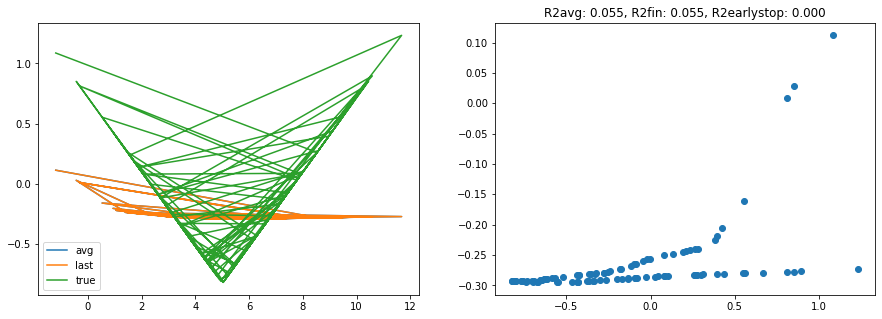

MSEavg 0.2271174
MSEfin 0.2271174


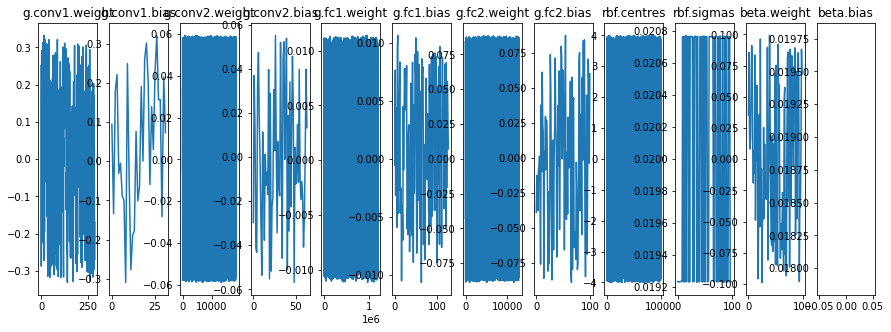

In [11]:
dropout_p = 0.1  # for dropout
n_t = 1  # number of treatments
n_hidden = 200

# For any method that use a projection of z into features g(z)
g_features = 100
n_centers = 100
sigma = 2.0 / g_features
# The kernel function
kernel_fn = gaussian
centers = np.random.uniform(-4, 4, size=(n_centers, 100))
sigmas = np.ones((n_centers,)) * sigma

# local hyperparam
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-4
adversary_l2 = 1e-4
adversary_norm_reg = 1e-4
n_epochs = 1
bs = 100

klayermmdgmm = train_kernellayergmm(
    Z_train,
    T_train,
    Y_train,
    G_train,
    Z_val,
    T_val,
    Y_val,
    G_val,
    T_test,
    G_test,
    g_features=g_features,
    kernel_fn=kernel_fn,
    centers=centers,
    sigmas=sigmas,
    X_IMAGE=False,
    Z_IMAGE=True,
    n_t=n_t,
    n_instruments=n_instruments,
    n_hidden=n_hidden,
    dropout_p=dropout_p,
    learner_lr=learner_lr,
    adversary_lr=adversary_lr,
    learner_l2=learner_l2,
    adversary_l2=adversary_l2,
    adversary_norm_reg=adversary_norm_reg,
    n_epochs=n_epochs,
    batch_size=bs,
)

plot_results(klayermmdgmm, T_test, true_of_T_test=G_test)

## X - Image

In [12]:
### Generate Data
if torch.cuda.is_available():
    torch.cuda.empty_cache()
X_IMAGE = True
Z_IMAGE = False
tau_fn = "abs"
n_samples = 20000
n_instruments = 1  # need to keep this to 1 for now. some bug in the way Bennett et al generate their data.
iv_strength = 0.5
data = generate_data(
    X_IMAGE=X_IMAGE,
    Z_IMAGE=Z_IMAGE,
    tau_fn=tau_fn,
    n_samples=n_samples,
    n_instruments=n_instruments,
    iv_strength=iv_strength,
    device=device,
)
(Z_train, T_train, Y_train, G_train) = data[0]
(Z_val, T_val, Y_val, G_val) = data[1]
(Z_test, T_test, Y_test, G_test) = data[2]

### Train AGMM - X image

In [13]:
# Train AGMM
#%%time

# if torch.cuda.is_available():
#  torch.cuda.empty_cache()
p = 0.1  # for dropout
n_t = 1  # number of treatments
n_hidden = 200

# local hyperparam
learner_lr = 1e-5
adversary_lr = 1e-4
learner_l2 = 1e-4
adversary_l2 = 1e-4
adversary_norm_reg = 1e-4
n_epochs = 1
bs = 100
train_learner_every = 1
train_adversary_every = 1

agmm = train_agmm(
    Z_train,
    T_train,
    Y_train,
    G_train,
    Z_val,
    T_val,
    Y_val,
    G_val,
    T_test,
    G_test,
    X_IMAGE=X_IMAGE,
    Z_IMAGE=Z_IMAGE,
    n_t=n_t,
    n_instruments=n_instruments,
    n_hidden=n_hidden,
    dropout_p=dropout_p,
    learner_lr=learner_lr,
    adversary_lr=adversary_lr,
    learner_l2=learner_l2,
    adversary_l2=adversary_l2,
    adversary_norm_reg=adversary_norm_reg,
    n_epochs=n_epochs,
    batch_size=bs,
    train_learner_every=train_learner_every,
    train_adversary_every=train_adversary_every,
)

eval_performance(agmm, T_test, true_of_T_test=G_test)

---Hyperparameters---
Learner Learning Rate: 1e-05
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100


AttributeError: 'NoneType' object has no attribute 'flatten'

### Train Kernel GMM - X image

In [14]:
# use KernelLayerGMM for DGP 2: only X image

# For any method that use a projection of z into features g(z)
g_features = 100
n_centers = 100
sigma = 2.0 / g_features
# The kernel function
kernel_fn = gaussian

centers = np.random.uniform(-4, 4, size=(n_centers, 100))
sigmas = np.ones((n_centers,)) * sigma

dropout_p = 0.1  # for dropout
n_t = 1  # number of treatments
n_hidden = 200
# local hyperparam
learner_lr = 1e-5
adversary_lr = 1e-4
learner_l2 = 1e-4
adversary_l2 = 1e-4
adversary_norm_reg = 1e-4
n_epochs = 1
bs = 100
train_learner_every = 1
train_adversary_every = 1

klayermmdgmm = train_kernellayergmm(
    Z_train,
    T_train,
    Y_train,
    G_train,
    Z_val,
    T_val,
    Y_val,
    G_val,
    T_test,
    G_test,
    g_features=g_features,
    kernel_fn=kernel_fn,
    centers=centers,
    sigmas=sigmas,
    X_IMAGE=X_IMAGE,
    Z_IMAGE=Z_IMAGE,
    n_t=n_t,
    n_instruments=n_instruments,
    n_hidden=n_hidden,
    dropout_p=dropout_p,
    learner_lr=learner_lr,
    adversary_lr=adversary_lr,
    learner_l2=learner_l2,
    adversary_l2=adversary_l2,
    adversary_norm_reg=adversary_norm_reg,
    n_epochs=n_epochs,
    batch_size=bs,
    train_learner_every=train_learner_every,
    train_adversary_every=train_adversary_every,
)

eval_performance(klayermmdgmm, T_test, true_of_T_test=G_test)

---Hyperparameters---
Learner Learning Rate: 1e-05
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100
G features 100
Number of centers 100
Kernel function gaussian


AttributeError: 'NoneType' object has no attribute 'flatten'

## X and Z - Images

In [15]:
### Generate Data
if torch.cuda.is_available():
    torch.cuda.empty_cache()
X_IMAGE = True
Z_IMAGE = True
tau_fn = "abs"
n_samples = 20000
n_instruments = 2
iv_strength = 0.5
data = generate_data(
    X_IMAGE=X_IMAGE,
    Z_IMAGE=Z_IMAGE,
    tau_fn=tau_fn,
    n_samples=n_samples,
    n_instruments=n_instruments,
    iv_strength=iv_strength,
    device=device,
)
(Z_train, T_train, Y_train, G_train) = data[0]
(Z_val, T_val, Y_val, G_val) = data[1]
(Z_test, T_test, Y_test, G_test) = data[2]

### Train AGMM - X and Z images

In [16]:
#%%time
dropout_p = 0.1  # for dropout
n_t = 1  # number of treatments
n_hidden = 200

# local hyperparam
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-4
adversary_l2 = 1e-4
adversary_norm_reg = 1e-4
n_epochs = 1
bs = 100


agmm = train_agmm(
    Z_train,
    T_train,
    Y_train,
    G_train,
    Z_val,
    T_val,
    Y_val,
    G_val,
    T_test,
    G_test,
    X_IMAGE=X_IMAGE,
    Z_IMAGE=Z_IMAGE,
    n_t=n_t,
    n_instruments=n_instruments,
    n_hidden=n_hidden,
    dropout_p=dropout_p,
    learner_lr=learner_lr,
    adversary_lr=adversary_lr,
    learner_l2=learner_l2,
    adversary_l2=adversary_l2,
    adversary_norm_reg=adversary_norm_reg,
    n_epochs=n_epochs,
    batch_size=bs,
    train_learner_every=train_learner_every,
    train_adversary_every=train_adversary_every,
)

eval_performance(agmm, T_test, true_of_T_test=G_test)

---Hyperparameters---
Learner Learning Rate: 0.0001
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100


AttributeError: 'NoneType' object has no attribute 'flatten'

### Train Kernel GMM - X and Z images

In [17]:
#%%time
# For any method that use a projection of z into features g(z)
g_features = 100
n_centers = 100
sigma = 2.0 / g_features
# The kernel function
kernel_fn = gaussian

centers = np.random.uniform(-4, 4, size=(n_centers, 100))
sigmas = np.ones((n_centers,)) * sigma

dropout_p = 0.1 # for dropout
n_t = 1 # number of treatments
n_hidden = 200

# training hyperparameters
learner_lr = 1e-5
adversary_lr = 1e-4
learner_l2 = 1e-4
adversary_l2 = 1e-4
adversary_norm_reg = 1e-4
n_epochs = 1
bs = 100
train_learner_every = 1
train_adversary_every = 1


klayermmdgmm = train_kernellayergmm(Z_train, T_train, Y_train, G_train,
                                    Z_val, T_val, Y_val, G_val, T_test, G_test,
                                    g_features=g_features, kernel_fn=kernel_fn,
                                    centers=centers, sigmas=sigmas,
                                    X_IMAGE=X_IMAGE, Z_IMAGE=Z_IMAGE, n_t=n_t,
                                    n_instruments=n_instruments,
                                    n_hidden=n_hidden, dropout_p=dropout_p, 
                                    learner_lr=learner_lr, adversary_lr=adversary_lr,
                                    learner_l2=learner_l2, adversary_l2=adversary_l2,
                                    adversary_norm_reg=adversary_norm_reg,
                                    n_epochs=n_epochs, batch_size=bs,
                                    train_learner_every=train_learner_every,
                                    train_adversary_every=train_adversary_every)

eval_performance(klayermmdgmm,T_test, true_of_T_test=G_test)

---Hyperparameters---
Learner Learning Rate: 1e-05
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100
G features 100
Number of centers 100
Kernel function gaussian


AttributeError: 'NoneType' object has no attribute 'flatten'

## Multiple Experiments at Once

In [18]:
def dgp_to_bools(dgp_str):
    x = False
    z = False
    if dgp_str=='mnist_x':
        x = True
    elif dgp_str== 'mnist_z':
        z = True
    elif dgp_str=='mnist_xz':
        x = True
        z = True
    return x,z

def experiment(dgp,iv_strength,tau_fn,num_data,est):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Experiment")
    print(dgp,est,iv_strength,tau_fn)

    # Fixed hyper-parameters - can vary these too
    # params for kernelgmm
    g_features = 100
    kernel_fn = gaussian
    centers = np.random.uniform(-4, 4, size=(n_centers, 100))
    sigmas = np.ones((n_centers,)) * sigma

    # arch params
    dropout_p = 0.1 # for dropout
    n_t = 1 # number of treatments
    n_hidden = 200

    # training params
    learner_lr = 1e-5
    adversary_lr = 1e-4
    learner_l2 = 1e-4
    adversary_l2 = 1e-4
    adversary_norm_reg = 1e-4
    n_epochs = 1
    bs = 100
    train_learner_every = 1
    train_adversary_every = 1

    # generate data
    X_IMAGE,Z_IMAGE = dgp_to_bools(dgp)
    n_instruments = 1
    data = generate_data(X_IMAGE=X_IMAGE, Z_IMAGE=Z_IMAGE, tau_fn=tau_fn, n_samples=num_data,
                    n_instruments=n_instruments, iv_strength=iv_strength, device=device)
    (Z_train, T_train, Y_train, G_train) = data[0]
    (Z_val, T_val, Y_val, G_val) = data[1]
    (Z_test, T_test, Y_test, G_test) = data[2]

    if est=='AGMM':
        estimator = train_agmm(Z_train, T_train, Y_train, G_train,
                               Z_val, T_val, Y_val, G_val, T_test, G_test,
                               X_IMAGE=X_IMAGE, Z_IMAGE=Z_IMAGE, n_t=n_t,
                               n_instruments=n_instruments,
                               n_hidden=n_hidden, dropout_p=dropout_p,
                               learner_lr=learner_lr, adversary_lr=adversary_lr,
                               learner_l2=learner_l2, adversary_l2=adversary_l2,
                               adversary_norm_reg=adversary_norm_reg, n_epochs=n_epochs,
                               batch_size=bs,
                               train_learner_every=train_learner_every,
                               train_adversary_every=train_adversary_every)

    elif est=='KernelLayerMMDGMM':
        estimator = train_kernellayergmm(Z_train, T_train, Y_train, G_train,
                                         Z_val, T_val, Y_val, G_val, T_test, G_test,
                                         g_features=g_features, kernel_fn=kernel_fn,
                                         centers=centers, sigmas=sigmas,
                                         X_IMAGE=X_IMAGE, Z_IMAGE=Z_IMAGE, n_t=n_t,
                                         n_instruments=n_instruments,
                                         n_hidden=n_hidden, dropout_p=dropout_p,
                                         learner_lr=learner_lr, adversary_lr=adversary_lr,
                                         learner_l2=learner_l2, adversary_l2=adversary_l2,
                                         adversary_norm_reg=adversary_norm_reg,
                                         n_epochs=n_epochs, batch_size=bs,
                                         train_learner_every=train_learner_every,
                                         train_adversary_every=train_adversary_every)

    results = eval_performance(estimator, T_test, true_of_T_test=G_test)
    return results


In [19]:
# Monte-Carlo Loop
# 1. loop over functions
# 2. loop over instrument strengths
# 3. loop over estimators
# 4. loop over dgps

tau_fns = ["abs", "sin", "2dpoly", "rand_pw", "3dpoly"]
iv_strength = [0.2, 0.5, 0.8]
estimators = ["AGMM", "KernelLayerMMDGMM"]
dgps = ["z_image", "x_image", "xz_image"]
num_datas = [1000]


hyperparams = list(itertools.product(tau_fns, iv_strength, dgps, num_datas, estimators))
result_dict = {}

for (tau_fn, iv_strength, dgp, num_data, est) in hyperparams:
    results = experiment(dgp, iv_strength, tau_fn, num_data, est)
    result_dict[(tau_fn, iv_strength, dgp, num_data, est)] = results

Experiment
z_image AGMM 0.2 abs
---Hyperparameters---
Learner Learning Rate: 1e-05
Adversary learning rate: 0.0001
Learner_l2: 0.0001
Adversary_l2: 0.0001
Number of epochs: 1
Batch Size: 100


AttributeError: 'NoneType' object has no attribute 'flatten'